<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Библиотеки,-служебные-функции,-загрузка-данных" data-toc-modified-id="Библиотеки,-служебные-функции,-загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Библиотеки, служебные функции, загрузка данных</a></span></li><li><span><a href="#FE" data-toc-modified-id="FE-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FE</a></span><ul class="toc-item"><li><span><a href="#Создание-новых-призанков" data-toc-modified-id="Создание-новых-призанков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Создание новых призанков</a></span></li><li><span><a href="#Вычисление-утечек" data-toc-modified-id="Вычисление-утечек-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Вычисление утечек</a></span></li><li><span><a href="#Проба-на-лидерборде-без-утечек" data-toc-modified-id="Проба-на-лидерборде-без-утечек-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Проба на лидерборде без утечек</a></span></li><li><span><a href="#Отбор-важных-признаков" data-toc-modified-id="Отбор-важных-признаков-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Отбор важных признаков</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li></ul></div>

## Библиотеки, служебные функции, загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install catboost
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 15.5 MB/s 
     |████████████████████████████████| 81 kB 10.8 MB/s 
     |████████████████████████████████| 209 kB 66.9 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
     |████████████████████████████████| 147 kB 73.2 MB/s 
     |████████████████████████████████| 112 kB 67.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=2a61f8b5cee3620e1890bc9aea66edb97146188b89cf254edddaec4c124c9858
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os
import pandas as pd
import re
import seaborn as sns
import warnings

from catboost import CatBoostClassifier, Pool
#from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.model_selection import  KFold, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OrdinalEncoder


warnings.simplefilter(action='ignore')

In [ ]:
types_full = {
 'index_oper': 'category',
 'oper_type': 'category',
 'oper_attr': 'category',
 'type': 'category',
 'priority': 'category',
 'is_privatecategory': 'category',
 'class': 'category',
 'is_in_yandex': 'category',
 'is_return': 'category',
 'weight': 'int32',
 'mailtype': 'category',
 'mailctg': 'category',
 'directctg': 'category',
 'transport_pay': 'float64',
 'postmark': 'category',
 'name_mfi': 'object',
 'weight_mfi': 'int16',
 'price_mfi': 'int32',
 'dist_qty_oper_login_1': 'int16',
 'total_qty_oper_login_1': 'int32',
 'total_qty_oper_login_0': 'int32',
 'total_qty_over_index_and_type': 'int32',
 'total_qty_over_index': 'int32',
 'is_wrong_sndr_name': 'category',
 'is_wrong_rcpn_name': 'category',
 'is_wrong_phone_number': 'category',
 'is_wrong_address': 'category',
 'label': 'int8',
 'oper_type': 'category',
 'oper_attr': 'category'}

In [ ]:
#show all columns and rows in pamdas:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Считаем наши данные
pth1 = '/content/drive/MyDrive/quests/post/X_full_india_last.csv' # серверный путь
pth2 = 'X_full_india_last.csv' # Локальный путь

if os.path.exists(pth1):
    X_full = pd.read_csv(pth1, dtype=types_full, index_col='id')
elif os.path.exists(pth2):
    X_full = pd.read_csv(pth2, dtype=types_full, index_col='id')
else:
    print('Something is wrong')  

In [ ]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5243313 entries, 6818780 to 6423388
Data columns (total 28 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   index_oper                     category
 1   type                           category
 2   priority                       category
 3   is_privatecategory             category
 4   class                          category
 5   is_in_yandex                   category
 6   is_return                      category
 7   weight                         int32   
 8   mailtype                       category
 9   mailctg                        category
 10  directctg                      category
 11  transport_pay                  float64 
 12  postmark                       category
 13  name_mfi                       object  
 14  weight_mfi                     int16   
 15  price_mfi                      int32   
 16  dist_qty_oper_login_1          int16   
 17  total_qty_oper_login_

In [ ]:
X_full.head()

,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,mailctg,directctg,transport_pay,postmark,name_mfi,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label,oper_type,oper_attr
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6818780,628629,Участок,7503,0,0,1,0,87,5,1,2,0.00,0,fishhook,41,150,42,720176,58950,779126,8290896,0,0,0,0,0,1043,-1
9907176,102976,ММПО,7503,0,0,0,0,107,5,1,2,0.00,0,screen protector,68,400,914,48856658,83318932,132175590,136819803,0,0,0,0,0,1023,-1
3304275,620962,Цех,7503,0,0,1,0,50,5,1,2,0.00,0,pendant necklaces,56,218,62,3246292,3233068,6479360,52708071,0,1,0,0,0,1018,-1
9020937,344964,Цех,7503,0,0,1,0,416,5,1,2,35.34,0,motorcycle signal lamp,33,100,55,2060928,653280,2714208,19562334,0,0,0,0,0,1019,-1
3082311,629819,Участок,7503,0,0,1,0,795,5,1,2,52.52,0,backpack,716,1000,16,316919,27911,344830,4719186,0,0,0,0,0,1020,-1


In [ ]:
def my_score_func(y_real, preds):
    recall = recall_score(y_real, preds,  average = "macro")
    auc_roc = roc_auc_score(y_real,  preds, multi_class='ovo')
    score = 0.1 * recall + 0.9 * auc_roc
    
    return score

my_scorer = make_scorer(my_score_func, greater_is_better=True)

In [ ]:
gc.collect()

217

## FE

### Создание новых призанков

In [ ]:
my_cols = ['dist_qty_oper_login_1', 'total_qty_oper_login_1',
'total_qty_oper_login_0', 'total_qty_over_index_and_type',
'total_qty_over_index']

In [ ]:
X_full[my_cols].mean().sort_values(ascending=False)

total_qty_over_index             7.061895e+07
total_qty_over_index_and_type    5.580372e+07
total_qty_oper_login_0           2.805586e+07
total_qty_oper_login_1           2.774785e+07
dist_qty_oper_login_1            3.154906e+02
dtype: float64

In [ ]:
def gen_nf(col1, col2):
  return X_full[col1] / X_full[col2]

In [ ]:
X_full['new_1'] = gen_nf('total_qty_oper_login_1', 'dist_qty_oper_login_1')
X_full['new_2'] = gen_nf('total_qty_oper_login_0', 'dist_qty_oper_login_1')
X_full['new_3'] = gen_nf('total_qty_over_index', 'dist_qty_oper_login_1')
X_full['new_4'] = gen_nf('total_qty_oper_login_0', 'total_qty_oper_login_1')
X_full['new_5'] = gen_nf('total_qty_over_index', 'total_qty_oper_login_1')
X_full['new_6'] = gen_nf('total_qty_over_index', 'total_qty_oper_login_0')
X_full['new_7'] = gen_nf('total_qty_over_index_and_type', 'dist_qty_oper_login_1')
X_full['new_8'] = gen_nf('total_qty_over_index_and_type', 'total_qty_oper_login_1')
X_full['new_9'] = gen_nf('total_qty_over_index_and_type', 'total_qty_oper_login_0')

X_full['new_10'] = gen_nf('total_qty_over_index', 'total_qty_over_index_and_type')

In [ ]:
X_full.head()

,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,mailctg,directctg,transport_pay,postmark,name_mfi,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label,oper_type,oper_attr,new_1,new_2,new_3,new_4,new_5,new_6,new_7,new_8,new_9,new_10
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6818780,628629,Участок,7503,0,0,1,0,87,5,1,2,0.00,0,fishhook,41,150,42,720176,58950,779126,8290896,0,0,0,0,0,1043,-1,17147.047619,1403.571429,197402.285714,0.081855,11.512319,140.642850,18550.619048,1.081855,13.216726,10.641278
9907176,102976,ММПО,7503,0,0,0,0,107,5,1,2,0.00,0,screen protector,68,400,914,48856658,83318932,132175590,136819803,0,0,0,0,0,1023,-1,53453.673961,91158.568928,149693.438731,1.705375,2.800433,1.642121,144612.242888,2.705375,1.586381,1.035137
3304275,620962,Цех,7503,0,0,1,0,50,5,1,2,0.00,0,pendant necklaces,56,218,62,3246292,3233068,6479360,52708071,0,1,0,0,0,1018,-1,52359.548387,52146.258065,850130.177419,0.995926,16.236392,16.302803,104505.806452,1.995926,2.004090,8.134765
9020937,344964,Цех,7503,0,0,1,0,416,5,1,2,35.34,0,motorcycle signal lamp,33,100,55,2060928,653280,2714208,19562334,0,0,0,0,0,1019,-1,37471.418182,11877.818182,355678.800000,0.316983,9.492003,29.944792,49349.236364,1.316983,4.154739,7.207382
3082311,629819,Участок,7503,0,0,1,0,795,5,1,2,52.52,0,backpack,716,1000,16,316919,27911,344830,4719186,0,0,0,0,0,1020,-1,19807.437500,1744.437500,294949.125000,0.088070,14.890827,169.079789,21551.875000,1.088070,12.354627,13.685544


In [ ]:
X_full.columns

Index(['index_oper', 'type', 'priority', 'is_privatecategory', 'class',
       'is_in_yandex', 'is_return', 'weight', 'mailtype', 'mailctg',
       'directctg', 'transport_pay', 'postmark', 'name_mfi', 'weight_mfi',
       'price_mfi', 'dist_qty_oper_login_1', 'total_qty_oper_login_1',
       'total_qty_oper_login_0', 'total_qty_over_index_and_type',
       'total_qty_over_index', 'is_wrong_sndr_name', 'is_wrong_rcpn_name',
       'is_wrong_phone_number', 'is_wrong_address', 'label', 'oper_type',
       'oper_attr', 'new_1', 'new_2', 'new_3', 'new_4', 'new_5', 'new_6',
       'new_7', 'new_8', 'new_9', 'new_10'],
      dtype='object')

In [ ]:
new_cols = ['new_1', 'new_2','new_3', 'new_4', 'new_5', 'new_6', 'new_7', 'new_8', 'new_9','new_10']

In [ ]:
X_full[new_cols] = X_full[new_cols].fillna(-1)

In [ ]:
X_full[new_cols] = X_full[new_cols].replace(0, -1)

In [ ]:
X_full[['new_1', 'new_2','new_3', 'new_4', 'new_5', 'new_6', 'new_7', 'new_8', 'new_9','new_10']].describe()

,new_1,new_2,new_3,new_4,new_5,new_6,new_7,new_8,new_9,new_10
count,5.243313e+06,5.243313e+06,5.243313e+06,5.243313e+06,5.243313e+06,5.243313e+06,5.243313e+06,5.243313e+06,5.243313e+06,5.243313e+06
mean,1.183333e+05,inf,inf,inf,inf,inf,inf,inf,inf,1.178357e+01
std,1.659037e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.189944e+03
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,2.706800e+04,3.680265e+02,1.496934e+05,9.841079e-03,2.106413e+00,1.759762e+00,3.655744e+04,1.009841e+00,1.754649e+00,1.035137e+00
50%,5.345367e+04,6.864250e+03,2.354805e+05,2.779202e-01,2.931499e+00,2.279240e+01,1.446122e+05,1.277920e+00,4.598156e+00,1.246905e+00
75%,1.291161e+05,9.115857e+04,4.381488e+05,1.325120e+00,1.141457e+01,5.749514e+02,1.963911e+05,2.325120e+00,9.609934e+01,8.875800e+00
max,1.792702e+06,inf,inf,inf,inf,inf,inf,inf,inf,1.873721e+07


In [ ]:
X_full.isna().sum()

index_oper                          0
type                                0
priority                            0
is_privatecategory                  0
class                               0
is_in_yandex                        0
is_return                           0
weight                              0
mailtype                            0
mailctg                             0
directctg                           0
transport_pay                       0
postmark                            0
name_mfi                         7017
weight_mfi                          0
price_mfi                           0
dist_qty_oper_login_1               0
total_qty_oper_login_1              0
total_qty_oper_login_0              0
total_qty_over_index_and_type       0
total_qty_over_index                0
is_wrong_sndr_name                  0
is_wrong_rcpn_name                  0
is_wrong_phone_number               0
is_wrong_address                    0
label                               0
oper_type   

In [ ]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5243313 entries, 6818780 to 6423388
Data columns (total 38 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   index_oper                     category
 1   type                           category
 2   priority                       category
 3   is_privatecategory             category
 4   class                          category
 5   is_in_yandex                   category
 6   is_return                      category
 7   weight                         int32   
 8   mailtype                       category
 9   mailctg                        category
 10  directctg                      category
 11  transport_pay                  float64 
 12  postmark                       category
 13  name_mfi                       object  
 14  weight_mfi                     int16   
 15  price_mfi                      int32   
 16  dist_qty_oper_login_1          int16   
 17  total_qty_oper_login_

In [ ]:
X_corr = X_full.drop(['new_4', 'new_5', 'new_2', 'new_7', 'total_qty_over_index_and_type'], axis=1)

In [ ]:
cols_c = ['dist_qty_oper_login_1', 'total_qty_oper_login_1',
       'total_qty_oper_login_0', 'total_qty_over_index',
        'new_1', 'new_3',
         'new_6', 'new_8', 'new_9', 'new_10']

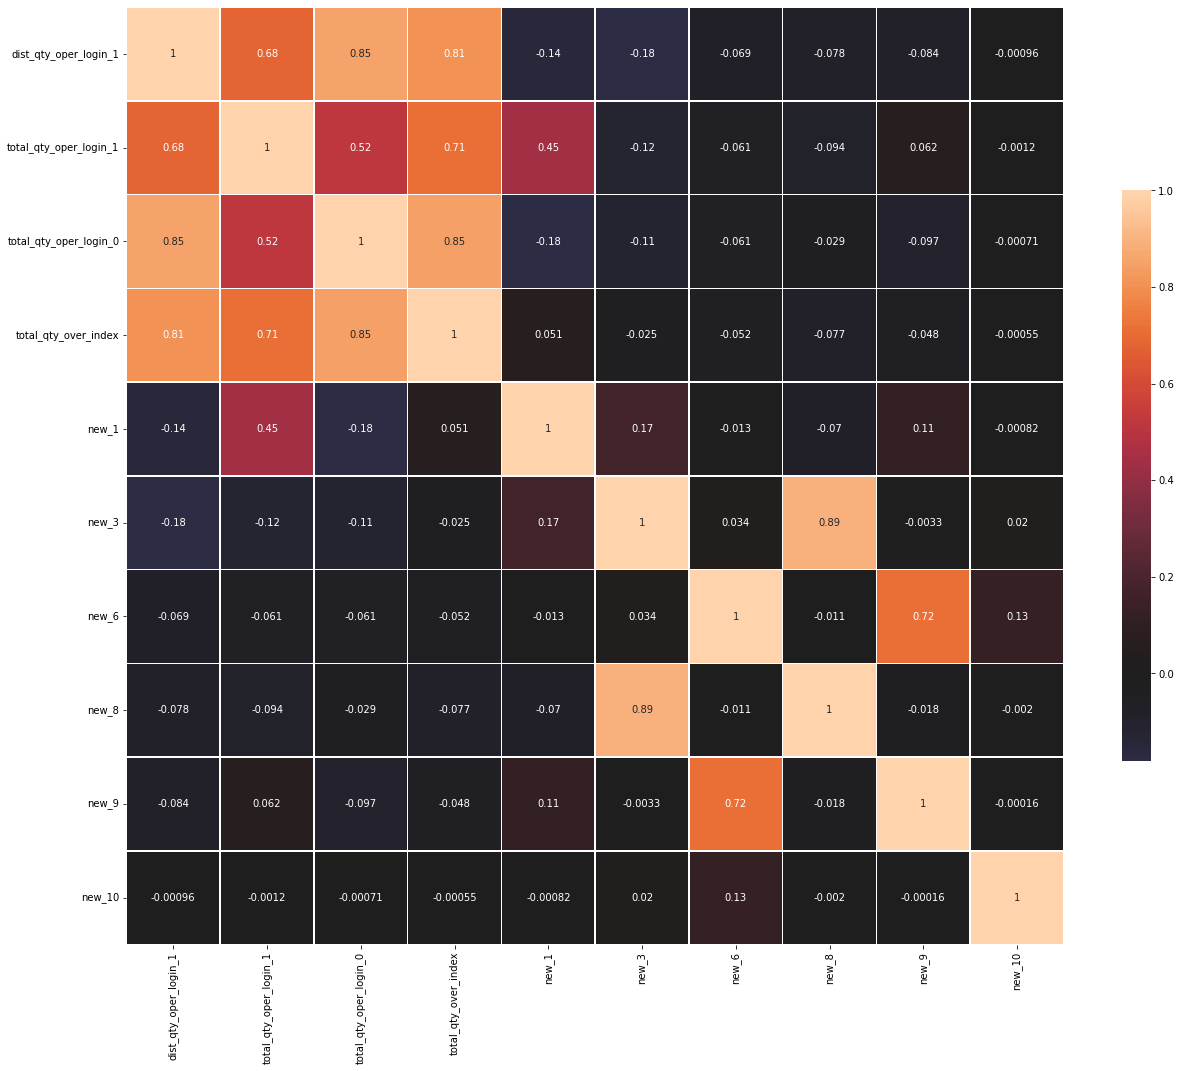

In [ ]:
ax = plt.subplots(figsize=(21, 21))
sns.heatmap(data=X_corr[cols_c].corr(), vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Вычисление утечек

НЕ ЗАПУСКАТЬ

In [ ]:
X_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5243313 entries, 6818780 to 6423388
Data columns (total 33 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   index_oper              category
 1   type                    category
 2   priority                category
 3   is_privatecategory      category
 4   class                   category
 5   is_in_yandex            category
 6   is_return               category
 7   weight                  int32   
 8   mailtype                category
 9   mailctg                 category
 10  directctg               category
 11  transport_pay           float64 
 12  postmark                category
 13  name_mfi                object  
 14  weight_mfi              int16   
 15  price_mfi               int32   
 16  dist_qty_oper_login_1   int16   
 17  total_qty_oper_login_1  int32   
 18  total_qty_oper_login_0  int32   
 19  total_qty_over_index    int32   
 20  is_wrong_sndr_name      category
 21  is

In [ ]:
cat_cols = [col for col in X_corr.columns if X_corr[col].dtype=='category']
cat_cols

['type',
 'priority',
 'is_privatecategory',
 'class',
 'is_in_yandex',
 'is_return',
 'mailtype',
 'mailctg',
 'directctg',
 'postmark',
 'is_wrong_sndr_name',
 'is_wrong_rcpn_name',
 'is_wrong_phone_number',
 'is_wrong_address',
 'oper_type',
 'oper_attr']

In [ ]:
text_cols = ['name_mfi']

In [ ]:
X_corr['name_mfi'] = X_corr['name_mfi'].fillna('missing')

In [ ]:
model = CatBoostClassifier(loss_function="Logloss",  verbose=False, auto_class_weights='Balanced', random_state=11,
                           task_type='GPU', gpu_ram_part=0.96, max_depth=3, cat_features=cat_cols, text_features=text_cols,
                           one_hot_max_size=10)

In [ ]:
X_t_c, X_v_c, y_t_c, y_t_v = train_test_split(X_corr, y, test_size=0.3, stratify=y)

In [ ]:
gc.collect()

328

In [ ]:
model.fit(X_t_c, y_t_c)

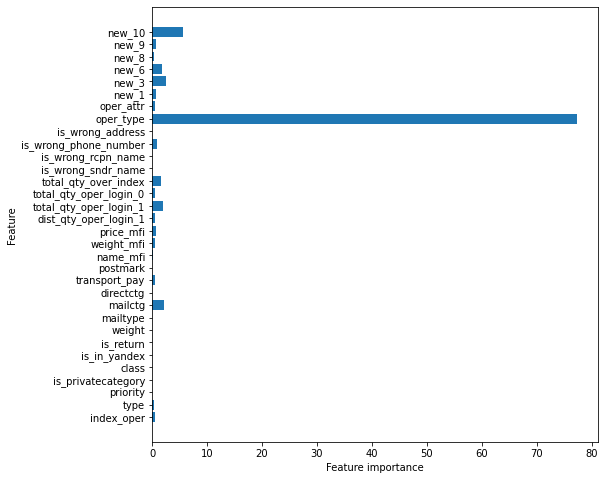

In [ ]:
n_features = X_t_c.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), model.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_t_c.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
preds = model.predict(X_v_c)

In [ ]:
my_score_func(y_t_v, preds)

0.9753913321905159

Oper_type - утечка, понижающая нам скор на тесте, oper_attr - тоже утчека

### Проба на лидерборде без утечек

In [ ]:
X_leak = X_corr.drop(['oper_type', 'oper_attr'], axis=1)

In [ ]:
X_leak ['name_mfi'] = X_leak['name_mfi'].fillna('missing')

Куча дубликатов без этих призанков

In [ ]:
X_leak.duplicated().sum()

3688913

In [ ]:
X_leak.drop_duplicates(inplace=True)
X_leak.duplicated().sum()

0

In [ ]:
X_leak.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1554400 entries, 6818780 to 8585377
Data columns (total 31 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   index_oper              1554400 non-null  category
 1   type                    1554400 non-null  category
 2   priority                1554400 non-null  category
 3   is_privatecategory      1554400 non-null  category
 4   class                   1554400 non-null  category
 5   is_in_yandex            1554400 non-null  category
 6   is_return               1554400 non-null  category
 7   weight                  1554400 non-null  int32   
 8   mailtype                1554400 non-null  category
 9   mailctg                 1554400 non-null  category
 10  directctg               1554400 non-null  category
 11  transport_pay           1554400 non-null  float64 
 12  postmark                1554400 non-null  category
 13  name_mfi                1554400 non-

In [ ]:
y = X_leak.label
X_leak.drop(['label'], axis=1, inplace=True)

In [ ]:
X_t_c, X_v_c, y_t_c, y_v_c = train_test_split(X_leak, y, test_size=0.3, stratify=y)

In [ ]:
cat_cols = [col for col in X_leak.columns if X_leak[col].dtype=='category']
text_cols = ['name_mfi']
cat_cols

['index_oper',
 'type',
 'priority',
 'is_privatecategory',
 'class',
 'is_in_yandex',
 'is_return',
 'mailtype',
 'mailctg',
 'directctg',
 'postmark',
 'is_wrong_sndr_name',
 'is_wrong_rcpn_name',
 'is_wrong_phone_number',
 'is_wrong_address']

In [ ]:
model = CatBoostClassifier(loss_function="Logloss",  verbose=False, auto_class_weights='Balanced', random_state=11,
                           task_type='GPU', gpu_ram_part=0.96, max_depth=3, cat_features=cat_cols, text_features=text_cols,
                           one_hot_max_size=10)

In [ ]:
gc.collect()

115

In [ ]:
model.fit(X_t_c, y_t_c)

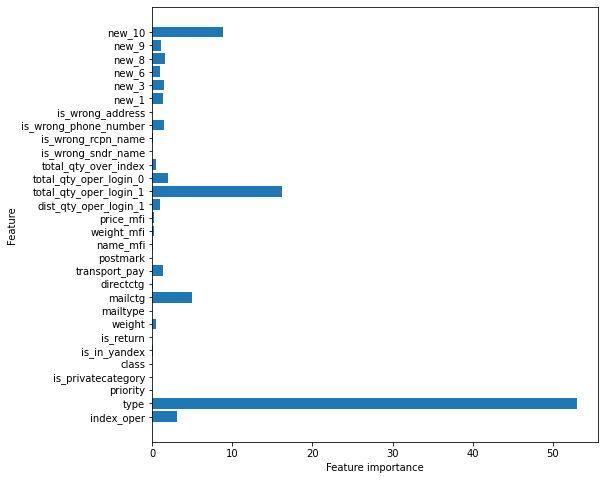

In [ ]:
n_features = X_t_c.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), model.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_t_c.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
preds = model.predict(X_v_c)

In [ ]:
my_score_func(y_v_c, preds)

0.8475841213684023

In [ ]:
X_leak.columns

Index(['index_oper', 'type', 'priority', 'is_privatecategory', 'class',
       'is_in_yandex', 'is_return', 'weight', 'mailtype', 'mailctg',
       'directctg', 'transport_pay', 'postmark', 'name_mfi', 'weight_mfi',
       'price_mfi', 'dist_qty_oper_login_1', 'total_qty_oper_login_1',
       'total_qty_oper_login_0', 'total_qty_over_index', 'is_wrong_sndr_name',
       'is_wrong_rcpn_name', 'is_wrong_phone_number', 'is_wrong_address',
       'new_1', 'new_3', 'new_6', 'new_8', 'new_9', 'new_10'],
      dtype='object')

In [ ]:
X_test = pd.read_csv('/content/drive/MyDrive/quests/post/X_test_india_last.csv', dtype=types_full, index_col='id')

In [ ]:
gc.collect()

22

In [ ]:
X_test.drop(['oper_type', 'oper_attr'], axis=1, inplace=True)

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000000 entries, 7815282 to 7776936
Data columns (total 25 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   index_oper                     category
 1   type                           category
 2   priority                       category
 3   is_privatecategory             category
 4   class                          category
 5   is_in_yandex                   category
 6   is_return                      category
 7   weight                         int32   
 8   mailtype                       category
 9   mailctg                        category
 10  directctg                      category
 11  transport_pay                  float64 
 12  postmark                       category
 13  name_mfi                       object  
 14  weight_mfi                     int16   
 15  price_mfi                      int32   
 16  dist_qty_oper_login_1          int16   
 17  total_qty_oper_login_

In [ ]:
def gen_nf(col1, col2):
  return X_test[col1] / X_test[col2]

In [ ]:
X_test['new_1'] = gen_nf('total_qty_oper_login_1', 'dist_qty_oper_login_1')
X_test['new_3'] = gen_nf('total_qty_over_index', 'dist_qty_oper_login_1')
X_test['new_6'] = gen_nf('total_qty_over_index', 'total_qty_oper_login_0')
X_test['new_8'] = gen_nf('total_qty_over_index_and_type', 'total_qty_oper_login_1')
X_test['new_9'] = gen_nf('total_qty_over_index_and_type', 'total_qty_oper_login_0')
X_test['new_10'] = gen_nf('total_qty_over_index', 'total_qty_over_index_and_type')

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000000 entries, 7815282 to 7776936
Data columns (total 31 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   index_oper                     category
 1   type                           category
 2   priority                       category
 3   is_privatecategory             category
 4   class                          category
 5   is_in_yandex                   category
 6   is_return                      category
 7   weight                         int32   
 8   mailtype                       category
 9   mailctg                        category
 10  directctg                      category
 11  transport_pay                  float64 
 12  postmark                       category
 13  name_mfi                       object  
 14  weight_mfi                     int16   
 15  price_mfi                      int32   
 16  dist_qty_oper_login_1          int16   
 17  total_qty_oper_login_

In [ ]:
new_cols = ['new_1', 'new_3', 'new_6', 'new_8', 'new_9', 'new_10']

In [ ]:
X_test[new_cols] = X_test[new_cols].fillna(-1)

In [ ]:
X_test[new_cols] = X_test[new_cols].replace(0, -1)

In [ ]:
X_test['name_mfi'] = X_test['name_mfi'].fillna('missing')

In [ ]:
X_test.isna().sum()

index_oper                       0
type                             0
priority                         0
is_privatecategory               0
class                            0
is_in_yandex                     0
is_return                        0
weight                           0
mailtype                         0
mailctg                          0
directctg                        0
transport_pay                    0
postmark                         0
name_mfi                         0
weight_mfi                       0
price_mfi                        0
dist_qty_oper_login_1            0
total_qty_oper_login_1           0
total_qty_oper_login_0           0
total_qty_over_index_and_type    0
total_qty_over_index             0
is_wrong_sndr_name               0
is_wrong_rcpn_name               0
is_wrong_phone_number            0
is_wrong_address                 0
new_1                            0
new_3                            0
new_6                            0
new_8               

In [ ]:
gc.collect()

214

In [ ]:
model = CatBoostClassifier(loss_function="Logloss",  verbose=False, auto_class_weights='Balanced', random_state=11,
                           task_type='GPU', gpu_ram_part=0.96, max_depth=3, cat_features=cat_cols, text_features=text_cols,
                           one_hot_max_size=10)

In [ ]:
model.fit(X_leak, y)

In [ ]:
X_test = X_test[X_leak.columns]

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000000 entries, 7815282 to 7776936
Data columns (total 30 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   index_oper              category
 1   type                    category
 2   priority                category
 3   is_privatecategory      category
 4   class                   category
 5   is_in_yandex            category
 6   is_return               category
 7   weight                  int32   
 8   mailtype                category
 9   mailctg                 category
 10  directctg               category
 11  transport_pay           float64 
 12  postmark                category
 13  name_mfi                object  
 14  weight_mfi              int16   
 15  price_mfi               int32   
 16  dist_qty_oper_login_1   int16   
 17  total_qty_oper_login_1  int32   
 18  total_qty_oper_login_0  int32   
 19  total_qty_over_index    int32   
 20  is_wrong_sndr_name      category
 21  is

In [ ]:
y_test = model.predict(X_test)

In [ ]:
y_test.mean()

0.27998725

In [ ]:
solution = pd.DataFrame(y_test, index=X_test.index, columns=['label']).reset_index()

display(solution.head())

#display(X_test.head())

solution.to_csv("/content/drive/MyDrive/quests/post/1411_india_leak2.csv",sep=",", index=False, line_terminator='\n')

,id,label
0,7815282,1
1,8443555,1
2,6352559,1
3,4921420,0
4,1420440,0


### Отбор важных признаков

In [ ]:
ordinal_encoder = OrdinalEncoder()

In [ ]:
X_full_r = X_leak.drop(['name_mfi'], axis=1)

In [ ]:
X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(X_full_r, y, test_size=0.21, stratify=y, random_state=11)

In [ ]:
X_train_r[['type']] = ordinal_encoder.fit_transform(X_train_r[['type']])
X_valid_r[['type']] = ordinal_encoder.transform(X_valid_r[['type']])

In [ ]:
X_train_r['type'] = X_train_r['type'].astype('category')
X_valid_r['type'] = X_valid_r['type'].astype('category')


In [ ]:
X_train_r['type'].sample(9)

id
53075       3.0
6105422     4.0
4924346    19.0
6857083     3.0
9841382    10.0
2587771    15.0
6663603     3.0
1217727     4.0
7344859    19.0
Name: type, dtype: category
Categories (20, float64): [0.0, 1.0, 2.0, 3.0, ..., 16.0, 17.0, 18.0, 19.0]

In [ ]:
for col in cat_cols:
  X_train_r[col] = X_train_r[col].astype('int')
  X_valid_r[col] = X_valid_r[col].astype('int')

In [ ]:
X_train_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1227976 entries, 7501592 to 387049
Data columns (total 29 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   index_oper              1227976 non-null  int64  
 1   type                    1227976 non-null  int64  
 2   priority                1227976 non-null  int64  
 3   is_privatecategory      1227976 non-null  int64  
 4   class                   1227976 non-null  int64  
 5   is_in_yandex            1227976 non-null  int64  
 6   is_return               1227976 non-null  int64  
 7   weight                  1227976 non-null  int32  
 8   mailtype                1227976 non-null  int64  
 9   mailctg                 1227976 non-null  int64  
 10  directctg               1227976 non-null  int64  
 11  transport_pay           1227976 non-null  float64
 12  postmark                1227976 non-null  int64  
 13  weight_mfi              1227976 non-null  int16  
 1

In [ ]:
model = CatBoostClassifier(loss_function="Logloss",  verbose=False, auto_class_weights='Balanced', random_state=11,
                           task_type='GPU', gpu_ram_part=0.96, max_depth=3)
                           #cat_features=cat_cols, one_hot_max_size=10) # **b_p)

In [ ]:
model.fit(X_train_r, y_train_r, eval_set=[(X_valid_r, y_valid_r)], early_stopping_rounds=99, verbose=False)

In [ ]:
feats_selector = RFECV(model, cv= 5, step=1, scoring=my_scorer)

In [ ]:
feats_selector = feats_selector.fit(X_train_r, y_train_r, )

In [ ]:
rfecv_mask = feats_selector.get_support() #list of booleans
rfecv_features = [] 
for bool, feature in zip(rfecv_mask, X_train_r.columns):
  if bool:
    rfecv_features.append(feature)

In [ ]:
print('Optimal number of features :', feats_selector.n_features_)
print('Best features :', rfecv_features)

Optimal number of features : 23
Best features : ['index_oper', 'type', 'is_privatecategory', 'class', 'is_in_yandex', 'weight', 'mailctg', 'directctg', 'transport_pay', 'weight_mfi', 'price_mfi', 'dist_qty_oper_login_1', 'total_qty_oper_login_1', 'total_qty_oper_login_0', 'total_qty_over_index', 'is_wrong_rcpn_name', 'is_wrong_phone_number', 'new_1', 'new_3', 'new_6', 'new_8', 'new_9', 'new_10']


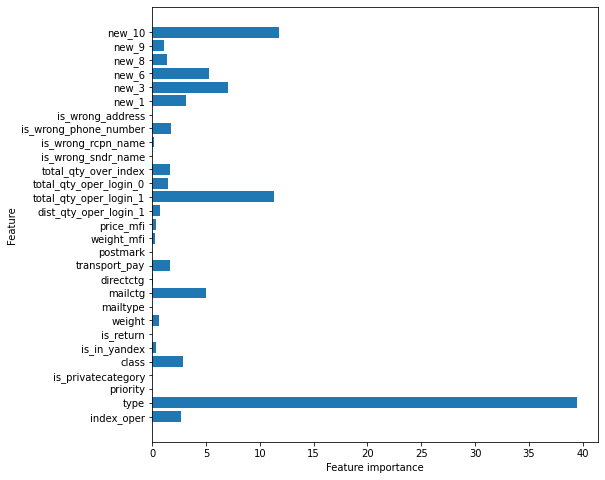

In [ ]:
n_features = X_train_r.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), model.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train_r.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

Optimal number of features : 23
Best features : ['index_oper', 'type', 'is_privatecategory', 'class', 'is_in_yandex', 'weight', 'mailctg', 'directctg', 'transport_pay', 'weight_mfi', 'price_mfi', 'dist_qty_oper_login_1', 'total_qty_oper_login_1', 'total_qty_oper_login_0', 'total_qty_over_index', 'is_wrong_rcpn_name', 'is_wrong_phone_number', 'new_1', 'new_3', 'new_6', 'new_8', 'new_9', 'new_10'

### CatBoost

In [ ]:
X_leak.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1554400 entries, 6818780 to 8585377
Data columns (total 30 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   index_oper              1554400 non-null  category
 1   type                    1554400 non-null  category
 2   priority                1554400 non-null  category
 3   is_privatecategory      1554400 non-null  category
 4   class                   1554400 non-null  category
 5   is_in_yandex            1554400 non-null  category
 6   is_return               1554400 non-null  category
 7   weight                  1554400 non-null  int32   
 8   mailtype                1554400 non-null  category
 9   mailctg                 1554400 non-null  category
 10  directctg               1554400 non-null  category
 11  transport_pay           1554400 non-null  float64 
 12  postmark                1554400 non-null  category
 13  name_mfi                1554400 non-

In [ ]:
display(y.shape)
X_leak.shape

(1554400,)

(1554400, 30)

In [ ]:
y.mean()

0.10417653113741637

Используем только те признаки, что отобрал RFECV

In [ ]:
X_main = X_leak[['index_oper', 'type', 'is_privatecategory', 'class', 'is_in_yandex',
                 'weight', 'mailctg', 'directctg', 'transport_pay', 'weight_mfi',
                 'price_mfi', 'dist_qty_oper_login_1', 'total_qty_oper_login_1',
                 'total_qty_oper_login_0', 'total_qty_over_index', 'is_wrong_rcpn_name',
                 'is_wrong_phone_number', 'new_1', 'new_3', 'new_6', 'new_8', 'new_9', 'new_10', 'name_mfi']]

In [ ]:
X_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1554400 entries, 6818780 to 8585377
Data columns (total 24 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   index_oper              1554400 non-null  category
 1   type                    1554400 non-null  category
 2   is_privatecategory      1554400 non-null  category
 3   class                   1554400 non-null  category
 4   is_in_yandex            1554400 non-null  category
 5   weight                  1554400 non-null  int32   
 6   mailctg                 1554400 non-null  category
 7   directctg               1554400 non-null  category
 8   transport_pay           1554400 non-null  float64 
 9   weight_mfi              1554400 non-null  int16   
 10  price_mfi               1554400 non-null  int32   
 11  dist_qty_oper_login_1   1554400 non-null  int16   
 12  total_qty_oper_login_1  1554400 non-null  int32   
 13  total_qty_oper_login_0  1554400 non-

In [ ]:
cat_cols = [col for col in X_main.columns if X_main[col].dtype=='category']
cat_cols

['index_oper',
 'type',
 'is_privatecategory',
 'class',
 'is_in_yandex',
 'mailctg',
 'directctg',
 'is_wrong_rcpn_name',
 'is_wrong_phone_number']

In [ ]:
text_cols = ['name_mfi']

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_main, y, test_size=0.3, stratify=y, random_state=11)

In [ ]:
def objective(trial, X_train=X_train, X_valid=X_valid, y_train=y_train, y_valid = y_valid, cat_cols=cat_cols, text_cols=text_cols):
    learn_pool = Pool(
        X_train, 
        y_train, 
        cat_features=cat_cols,
        text_features=text_cols,
        feature_names=list(X_train)
    )
    valid_pool = Pool(
        X_valid, 
        y_valid, 
        cat_features=cat_cols,
        text_features=text_cols,
        feature_names=list(X_train)
    )
    param = {
        #'cat_features': cat_cols,
        'one_hot_max_size': 10,
        'verbose': False,
        'loss_function': 'Logloss',
        'task_type': 'GPU',
        'gpu_ram_part': 0.96,
        'auto_class_weights': trial.suggest_categorical("auto_class_weights", ["Balanced"]),
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.001, 9),
        # "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bernoulli"]), #,"Bayesian", "MVS"]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators':  trial.suggest_int('n_estimators', 150, 3000),
        'max_depth': trial.suggest_categorical('max_depth', [4, 5 ,6, 7, 8, 9, 10, 11, 12,
                                                             13, 14, 15, 16]),
        'random_state': trial.suggest_categorical('random_state', [11]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100)
      #   "tokenizers" : [{"tokenizer_id" : "Sence", 
      #                    "separator_type" : "BySense", 
      #                    'lowercasing': 'True',
      #                    'token_types':['Word'],
      #                    'sub_tokens_policy':'SeveralTokens'
      #                    }],

      #  "dictionaries" : [{"dictionary_id" : "BiGram", 
      #                     "max_dictionary_size" : "50000",
      #                     "occurrence_lower_bound" : "3",
      #                     "gram_order" : "2"
      #                    },
      #                    {"dictionary_id" : "Word",
      #                     "max_dictionary_size" : "50000",
      #                     "occurrence_lower_bound" : "3",
      #                     "gram_order" : "1",
      #                     "min_token_occurrence": "5"
      #                     }],
             
      # 'feature_calcers': ['BoW:top_tokens_count=3000'],

      # "feature_processing" : {
      #     "default" : [{
      #         "dictionaries_names" : ["BiGram", "Word"],
      #         "feature_calcers" : ["BoW"],
      #         "tokenizers_names" : ["Space"]
      #      }, {"dictionaries_names" : ["Word"],
      #          "feature_calcers" : ["NaiveBayes"],
      #          "tokenizers_names" : ["Space"]
      #          }],
      #  }
        
    }


    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)
    
    #cv=StratifiedKFold(n_splits=5, random_state=23071983, shuffle=True)
    
    model = CatBoostClassifier(**param)  
    model.fit(learn_pool, eval_set=valid_pool, early_stopping_rounds=99, verbose=False)
    preds = model.predict(X_valid)
    score = my_score_func(y_valid, preds)
    
    return score #cross_val_score(model, X_train, y_train,cv=cv,scoring=my_scorer, verbose=False).mean()

In [ ]:
gc.collect()

66

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1088080 entries, 7762582 to 387049
Data columns (total 24 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   index_oper              1088080 non-null  category
 1   type                    1088080 non-null  category
 2   is_privatecategory      1088080 non-null  category
 3   class                   1088080 non-null  category
 4   is_in_yandex            1088080 non-null  category
 5   weight                  1088080 non-null  int32   
 6   mailctg                 1088080 non-null  category
 7   directctg               1088080 non-null  category
 8   transport_pay           1088080 non-null  float64 
 9   weight_mfi              1088080 non-null  int16   
 10  price_mfi               1088080 non-null  int32   
 11  dist_qty_oper_login_1   1088080 non-null  int16   
 12  total_qty_oper_login_1  1088080 non-null  int32   
 13  total_qty_oper_login_0  1088080 non-n

In [ ]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466320 entries, 7395779 to 6428208
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   index_oper              466320 non-null  category
 1   type                    466320 non-null  category
 2   is_privatecategory      466320 non-null  category
 3   class                   466320 non-null  category
 4   is_in_yandex            466320 non-null  category
 5   weight                  466320 non-null  int32   
 6   mailctg                 466320 non-null  category
 7   directctg               466320 non-null  category
 8   transport_pay           466320 non-null  float64 
 9   weight_mfi              466320 non-null  int16   
 10  price_mfi               466320 non-null  int32   
 11  dist_qty_oper_login_1   466320 non-null  int16   
 12  total_qty_oper_login_1  466320 non-null  int32   
 13  total_qty_oper_login_0  466320 non-null  int32   
 1

In [ ]:
display(y_train.mean())
y_train.shape

0.10417616351738843

(1088080,)

In [ ]:
display(y_valid.mean())
y_valid.shape

0.10417738891748156

(466320,)

In [ ]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=9))
study.optimize(objective, n_trials=3333, timeout=5400)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
study.best_value

[I 2022-11-15 07:01:35,441] A new study created in memory with name: no-name-7f4edac9-efc5-4132-934d-da3ed83025ad
[I 2022-11-15 07:02:49,604] Trial 0 finished with value: 0.852794215193469 and parameters: {'auto_class_weights': 'Balanced', 'objective': 'Logloss', 'l2_leaf_reg': 2.0469365299163096, 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.05334125360222045, 'n_estimators': 1023, 'max_depth': 5, 'random_state': 11, 'min_data_in_leaf': 69, 'subsample': 0.7043789492697284}. Best is trial 0 with value: 0.852794215193469.
[I 2022-11-15 07:13:57,372] Trial 1 finished with value: 0.8519103318464235 and parameters: {'auto_class_weights': 'Balanced', 'objective': 'Logloss', 'l2_leaf_reg': 2.2461300240753386, 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.022384280607937214, 'n_estimators': 1123, 'max_depth': 15, 'random_state': 11, 'min_data_in_leaf': 70, 'subsample': 0.11019723846435718}. Best is trial 0 with value: 0.852794215193469.
[I 2022-11-15 07:17:46,837] Trial 2 finished wit

Number of finished trials: 25
Best trial: {'auto_class_weights': 'Balanced', 'objective': 'Logloss', 'l2_leaf_reg': 6.024909514859491, 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.054451421542168844, 'n_estimators': 1628, 'max_depth': 10, 'random_state': 11, 'min_data_in_leaf': 38, 'subsample': 0.9893630083427628}


0.8554004942551644

Number of finished trials: 25
Best trial: {'auto_class_weights': 'Balanced', 'objective': 'Logloss', 'l2_leaf_reg': 6.024909514859491, 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.054451421542168844, 'n_estimators': 1628, 'max_depth': 10, 'random_state': 11, 'min_data_in_leaf': 38, 'subsample': 0.9893630083427628}
0.8554004942551644

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
#b_p = study.best_params
b_p = {'auto_class_weights': 'Balanced',
       'objective': 'Logloss',
       'l2_leaf_reg': 6.024909514859491,
       'bootstrap_type': 'Bernoulli',
       'learning_rate': 0.054451421542168844,
       'n_estimators': 1628,
       'max_depth': 10,
       'random_state': 11,
       'min_data_in_leaf': 38,
       'subsample': 0.9893630083427628}

In [ ]:
learn_pool = Pool(
        X_train, 
        y_train, 
        cat_features=cat_cols,
        text_features=text_cols,
        feature_names=list(X_train)
    )
valid_pool = Pool(
        X_valid, 
        y_valid, 
        cat_features=cat_cols,
        text_features=text_cols,
        feature_names=list(X_train)
)

In [ ]:
def score_dataset(model, valid_pool=valid_pool, y_valid=y_valid):
    """
    Возвращает кортеж оценок (accuracy, precision, recall, f1)
    из модели model и указанных обучающих и валидационных выборок
    """
    preds = model.predict(valid_pool)
    return(accuracy_score(y_valid, preds),
           precision_score(y_valid, preds),
           recall_score(y_valid, preds, average = "macro"),
           f1_score(y_valid, preds),
           my_score_func(y_valid, preds)), preds

In [ ]:
def plot_roc_auc(model, valid_pool=valid_pool, y_valid=y_valid):
    '''
    Строит ROC-curve и возвращает AUC-score для заданной модели model
    и заданных выборок X_valid, y_valid
    '''
    probabilities_valid = model.predict_proba(valid_pool)
    probabilities_one_valid = probabilities_valid[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid) 

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, linestyle='-')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-curve')
    plt.show()
    print(f"AUC-score: {roc_auc_score(y_valid, probabilities_one_valid, multi_class='ovo')}")

In [ ]:
params = {'verbose': False, 'loss_function': 'Logloss', 'task_type': 'GPU', 'gpu_ram_part': 0.96, 'one_hot_max_size': 10}

In [ ]:
model_cb = CatBoostClassifier(**params, **b_p)

In [ ]:
model_cb.get_params()

{'learning_rate': 0.054451421542168844,
 'l2_leaf_reg': 6.024909514859491,
 'loss_function': 'Logloss',
 'verbose': False,
 'auto_class_weights': 'Balanced',
 'one_hot_max_size': 10,
 'gpu_ram_part': 0.96,
 'task_type': 'GPU',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.9893630083427628,
 'max_depth': 10,
 'n_estimators': 1628,
 'random_state': 11,
 'objective': 'Logloss',
 'min_data_in_leaf': 38}

In [ ]:
model_cb.fit(learn_pool, eval_set=valid_pool, early_stopping_rounds=99, verbose=False)

In [ ]:
model_cb.get_feature_importance(prettified=True)

,Feature Id,Importances
0,type,21.628051
1,total_qty_oper_login_1,12.150455
2,new_10,10.785224
3,mailctg,6.994994
4,new_3,5.228840
5,transport_pay,4.489077
6,new_6,4.235455
7,new_9,4.139543
8,weight,3.368034
9,is_wrong_phone_number,3.176786


In [ ]:
scores = score_dataset(model_cb)
#plot_confusion_matrix(model_cb, X=X_valid, y_true=y_valid, normalize=None, cmap='Blues')
print(f'Показатели итоговой модели: accuracy={scores[0][0]:0.2}, precision={scores[0][1]:0.2}, \
recall={scores[0][2]:0.2}, f1={scores[0][3]:0.4}, my_score={scores[0][4]:0.6}')

Показатели итоговой модели: accuracy=0.78, precision=0.32, recall=0.86, f1=0.4742, my_score=0.855396


In [ ]:
preds = scores[1]

In [ ]:
my_score_func(y_valid, preds)

0.8553957065881943

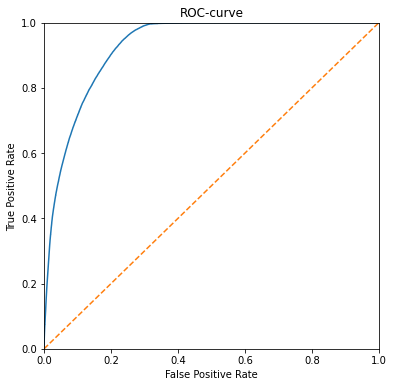

AUC-score: 0.9270850028490463


In [ ]:
plot_roc_auc(model_cb)

Threshold = 0.0 |, Recall = 0.5000,     roc_auc_score = 0.5 | my_score = 0.5 
Threshold = 0.01 |, Recall = 0.7794,     roc_auc_score = 0.7794 | my_score = 0.779418 
Threshold = 0.02 |, Recall = 0.8115,     roc_auc_score = 0.8115 | my_score = 0.811542 
Threshold = 0.03 |, Recall = 0.8277,     roc_auc_score = 0.8277 | my_score = 0.827675 
Threshold = 0.04 |, Recall = 0.8330,     roc_auc_score = 0.833 | my_score = 0.832953 
Threshold = 0.05 |, Recall = 0.8349,     roc_auc_score = 0.8349 | my_score = 0.834916 
Threshold = 0.06 |, Recall = 0.8363,     roc_auc_score = 0.8363 | my_score = 0.836328 
Threshold = 0.07 |, Recall = 0.8373,     roc_auc_score = 0.8373 | my_score = 0.837256 
Threshold = 0.08 |, Recall = 0.8379,     roc_auc_score = 0.8379 | my_score = 0.837944 
Threshold = 0.09 |, Recall = 0.8384,     roc_auc_score = 0.8384 | my_score = 0.838412 
Threshold = 0.1 |, Recall = 0.8389,     roc_auc_score = 0.8389 | my_score = 0.838896 
Threshold = 0.11 |, Recall = 0.8393,     roc_auc_score

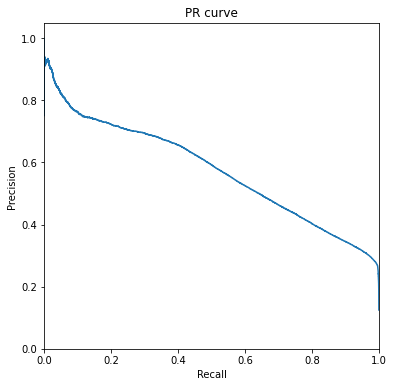

In [ ]:
probabilities_valid = model_cb.predict_proba(valid_pool)
probabilities_one_valid = probabilities_valid[:, 1]

roc_auc_score(y_valid, probabilities_one_valid)


for threshold in np.arange(0, 1, 0.01):
    predicted_valid = probabilities_one_valid >= threshold
    # precision = precision_score(y_valid, predicted_valid)
    recall = recall_score(y_valid, predicted_valid, average = "macro")
    # f1 = f1_score(y_valid, predicted_valid)
    ras = roc_auc_score(y_valid, predicted_valid, multi_class='ovo')
    my_score = my_score_func(y_valid, predicted_valid)
    print(f"Threshold = {threshold:.4} |, Recall = {recall:.4f}, \
    roc_auc_score = {ras:.4} | my_score = {my_score:.6} ")
    
precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_valid[:, 1])    
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show() 

In [ ]:
X_test = X_test[X_main.columns]

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000000 entries, 7815282 to 7776936
Data columns (total 24 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   index_oper              category
 1   type                    category
 2   is_privatecategory      category
 3   class                   category
 4   is_in_yandex            category
 5   weight                  int32   
 6   mailctg                 category
 7   directctg               category
 8   transport_pay           float64 
 9   weight_mfi              int16   
 10  price_mfi               int32   
 11  dist_qty_oper_login_1   int16   
 12  total_qty_oper_login_1  int32   
 13  total_qty_oper_login_0  int32   
 14  total_qty_over_index    int32   
 15  is_wrong_rcpn_name      category
 16  is_wrong_phone_number   category
 17  new_1                   float64 
 18  new_3                   float64 
 19  new_6                   float64 
 20  new_8                   float64 
 21  ne

In [ ]:
model = CatBoostClassifier(loss_function="Logloss",  verbose=False,
                           task_type='GPU', gpu_ram_part=0.96, cat_features=cat_cols, text_features=text_cols,
                           one_hot_max_size=10, **b_p)

In [ ]:
model.get_params()

{'learning_rate': 0.054451421542168844,
 'l2_leaf_reg': 6.024909514859491,
 'loss_function': 'Logloss',
 'verbose': False,
 'auto_class_weights': 'Balanced',
 'one_hot_max_size': 10,
 'gpu_ram_part': 0.96,
 'task_type': 'GPU',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.9893630083427628,
 'max_depth': 10,
 'n_estimators': 1628,
 'random_state': 11,
 'objective': 'Logloss',
 'cat_features': ['index_oper',
  'type',
  'is_privatecategory',
  'class',
  'is_in_yandex',
  'mailctg',
  'directctg',
  'is_wrong_rcpn_name',
  'is_wrong_phone_number'],
 'min_data_in_leaf': 38,
 'text_features': ['name_mfi']}

In [ ]:
model.fit(X_main, y)

In [ ]:
X_test.isna().sum()

index_oper                0
type                      0
is_privatecategory        0
class                     0
is_in_yandex              0
weight                    0
mailctg                   0
directctg                 0
transport_pay             0
weight_mfi                0
price_mfi                 0
dist_qty_oper_login_1     0
total_qty_oper_login_1    0
total_qty_oper_login_0    0
total_qty_over_index      0
is_wrong_rcpn_name        0
is_wrong_phone_number     0
new_1                     0
new_3                     0
new_6                     0
new_8                     0
new_9                     0
new_10                    0
name_mfi                  0
dtype: int64

In [ ]:
y_test = model.predict(X_test)

In [ ]:
y_test.mean()

0.2079615

In [ ]:
solution = pd.DataFrame(y_test, index=X_test.index, columns=['label']).reset_index()

display(solution.head())


solution.to_csv("/content/drive/MyDrive/quests/post/1511_india_final.csv",sep=",", index=False, line_terminator='\n')

,id,label
0,7815282,1
1,8443555,1
2,6352559,1
3,4921420,0
4,1420440,0
